In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fft import fft, ifft, fftfreq
import scipy
import random
from scipy.signal import butter, filtfilt

In [30]:
def compute_spectrum(signal, fs):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / fs)[:N // 2]
    return xf, np.abs(yf[:N // 2])

# 1.

In [7]:
def remove_outliers(signal, threshold=2):
    mean = np.mean(signal)
    std = np.std(signal)
    is_outlier = np.abs(signal - mean) > threshold * std
    clean_signal = signal.copy()
    clean_signal[is_outlier] = mean
    return clean_signal

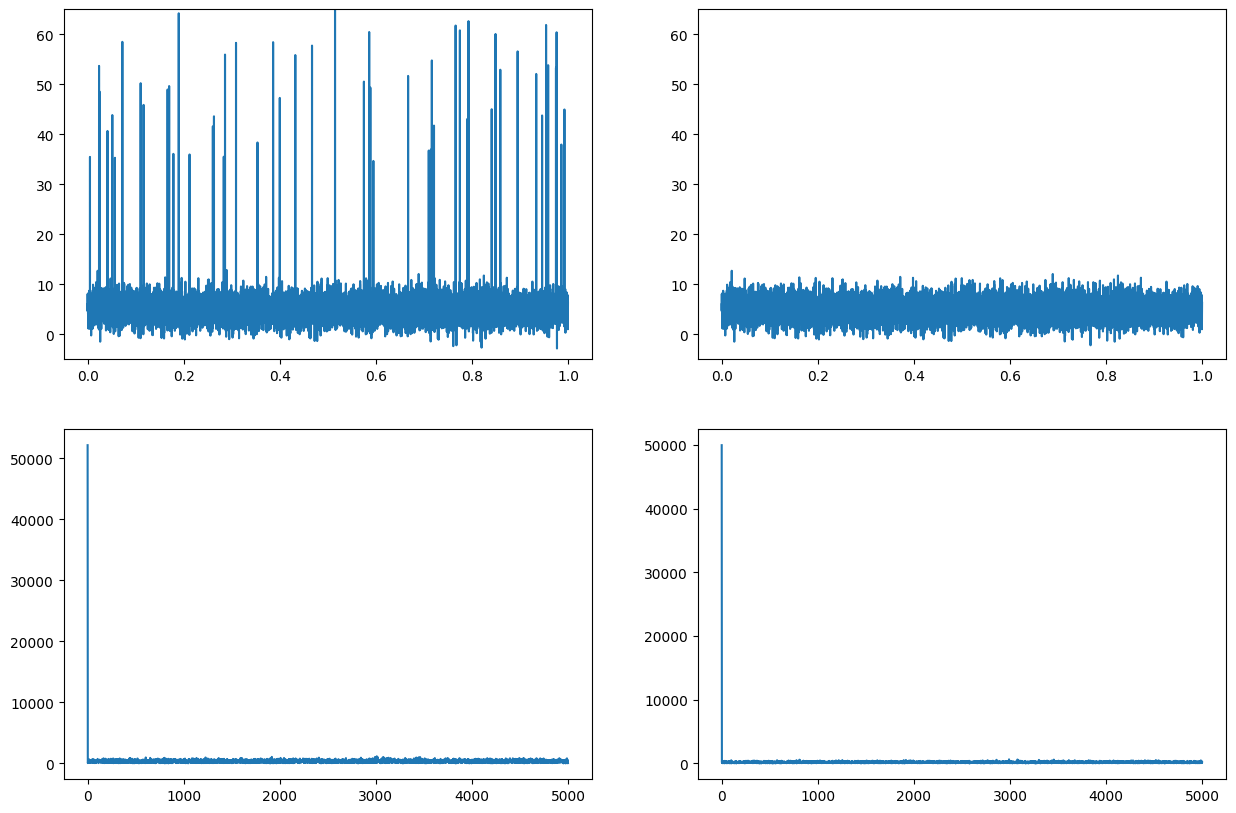

In [32]:
np.random.seed(42) 
fs = 10000
x = np.linspace(0, 1, fs) 
signal = np.random.normal(loc=5, scale=2, size=len(x)) 
signal[np.random.randint(0, len(x), 50)] += np.random.randint(30, 60, 50)
signal_fft, y_fft = compute_spectrum(signal, fs)

signal_clean = remove_outliers(signal)
signal_clean_fft, y_clean_fft = compute_spectrum(signal_clean, fs)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.ylim(-5, 65)
plt.plot(x, signal)

plt.subplot(2, 2, 2)
plt.ylim(-5, 65)
plt.plot(x, signal_clean)

plt.subplot(2, 2, 3)
plt.plot(signal_fft, y_fft)

plt.subplot(2, 2, 4)
plt.plot(signal_clean_fft, y_clean_fft)

# 2.

In [19]:
def generate_noisy_signal(x, noise_intervals, noise_level):
    signal = np.sin(2 * np.pi * x)  
    noise = np.random.normal(loc=0, scale=0.1, size=len(x))  
    signal += noise
    
    for start, end in noise_intervals:
        indices = (x >= start) & (x <= end)
        signal[indices] += np.random.normal(loc=0, scale=noise_level, size=np.sum(indices))  
    return signal

In [20]:
def sliding_rms(signal, window_size):
    smoothed_signal = np.zeros_like(signal)
    half_window = window_size // 2
    
    for i in range(len(signal)):
        start = max(0, i - half_window)
        end = min(len(signal), i + half_window + 1)
        window = signal[start:end]
        rms = np.sqrt(np.mean(window**2))
        smoothed_signal[i] = rms
    return smoothed_signal


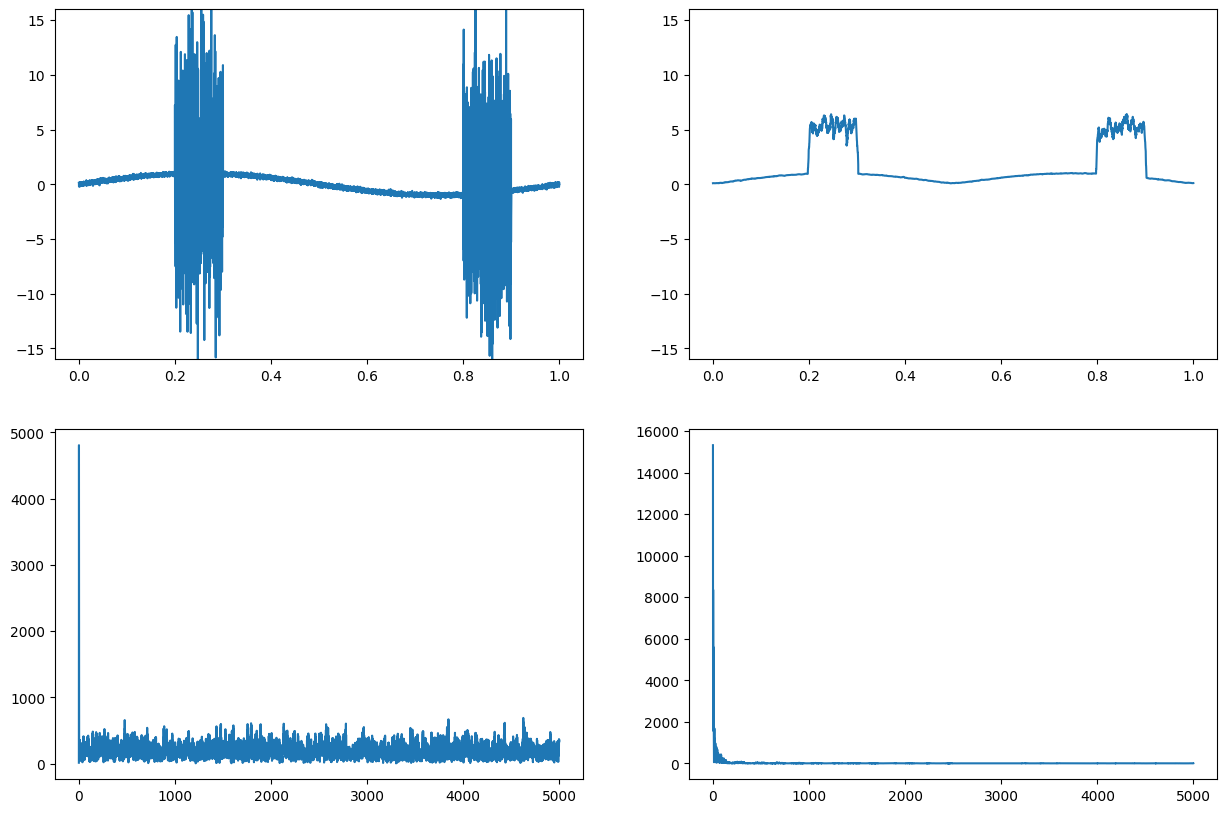

In [34]:
x = np.linspace(0, 1, 10000)  # Временные метки
noise_intervals = [(0.2, 0.3), (0.8, 0.9)]  # Интервалы шума
signal = generate_noisy_signal(x, noise_intervals, noise_level=5)
signal_fft, y_fft = compute_spectrum(signal, fs)

window_size = 50  # Размер окна
signal_clean = sliding_rms(signal, window_size)
signal_clean_fft, y_clean_fft = compute_spectrum(signal_clean, fs)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.ylim(-16, 16)
plt.plot(x, signal)

plt.subplot(2, 2, 2)
plt.ylim(-16, 16)
plt.plot(x, signal_clean)

plt.subplot(2, 2, 3)
plt.plot(signal_fft, y_fft)

plt.subplot(2, 2, 4)
plt.plot(signal_clean_fft, y_clean_fft)

# 3.

In [42]:
def spectral_interpolation(signal, gap_start, gap_end, window_size):
    """
    Восстанавливает потерянную часть сигнала с помощью спектральной интерполяции.

    Параметры:
        signal (np.ndarray): Исходный сигнал с утраченной частью.
        gap_start (int): Индекс начала утраченной области.
        gap_end (int): Индекс конца утраченной области.
        window_size (int): Размер окна для определения спектра.

    Возвращает:
        np.ndarray: Восстановленный сигнал.
    """
    # Определяем окна слева и справа от утраченной области
    left_start = max(0, gap_start - window_size)
    left_end = gap_start
    right_start = gap_end
    right_end = min(len(signal), gap_end + window_size)

    left_window = signal[left_start:left_end]
    right_window = signal[right_start:right_end]

    # Вычисляем спектры окон
    left_spectrum = np.fft.fft(left_window)
    right_spectrum = np.fft.fft(right_window)

    # Усредняем спектры
    avg_spectrum = (left_spectrum + right_spectrum) / 2

    # Восстанавливаем утраченные точки с использованием усредненного спектра
    restored_length = gap_end - gap_start
    restored_freqs = np.fft.ifft(avg_spectrum).real

    # Урезаем восстановленный сигнал до необходимого размера
    restored_gap = restored_freqs[:restored_length]

    # Сшиваем границы
    restored_signal = signal.copy()
    restored_signal[gap_start:gap_end] = restored_gap
    return restored_signal

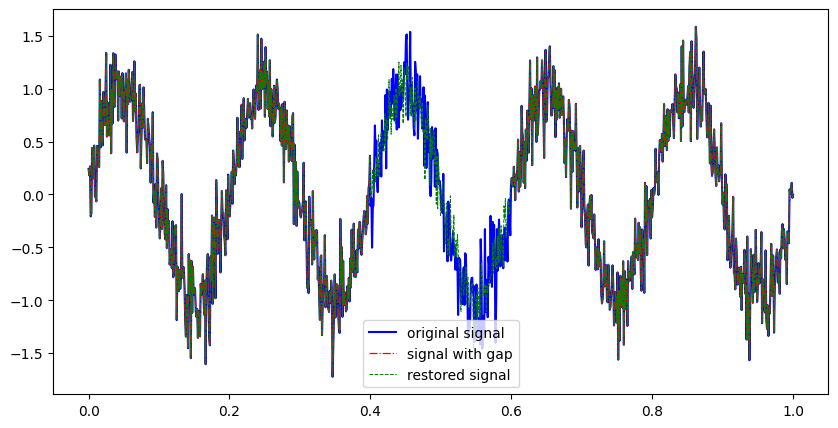

In [54]:
x = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * x) + 0.25 * np.random.normal(size=len(x))

gap_start, gap_end = 400, 600
signal_with_gap = signal.copy()
signal_with_gap[gap_start:gap_end] = np.nan

window_size = 200
restored_signal = spectral_interpolation(signal_with_gap, gap_start, gap_end, window_size)

plt.figure(figsize=(10, 5))
plt.plot(x, signal, color='blue', linestyle='-', label='original signal')
plt.plot(x, signal_with_gap, color='red', linestyle='-.', label='signal with gap', linewidth=0.9)
plt.plot(x, restored_signal, color='green', linestyle='--', label='restored signal', linewidth=0.7)
plt.legend()

# 4.

In [69]:
def downsample_signal(signal, sampling_rate, factor):
    new_sampling_rate = sampling_rate / factor

    nyquist_freq = new_sampling_rate / 2
    b, a = butter(4, nyquist_freq / (sampling_rate / 2), btype='low')  # Нормализация частоты
    filtered_signal = filtfilt(b, a, signal)

    # Уменьшаем число точек в сигнале
    downsampled_signal = filtered_signal[::factor]

    return downsampled_signal, new_sampling_rate

In [70]:
def upsample_signal(signal, sampling_rate, factor):
    new_sampling_rate = sampling_rate * factor

    # Создаем временную ось для увеличенного сигнала
    original_time = np.linspace(0, len(signal) / sampling_rate, len(signal), endpoint=False)
    upsampled_time = np.linspace(0, len(signal) / sampling_rate, len(signal) * factor, endpoint=False)

    # Интерполяция
    upsampled_signal = np.interp(upsampled_time, original_time, signal)

    return upsampled_signal, new_sampling_rate

C:\Users\IvanK\AppData\Local\Temp\ipykernel_23248\2297677111.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


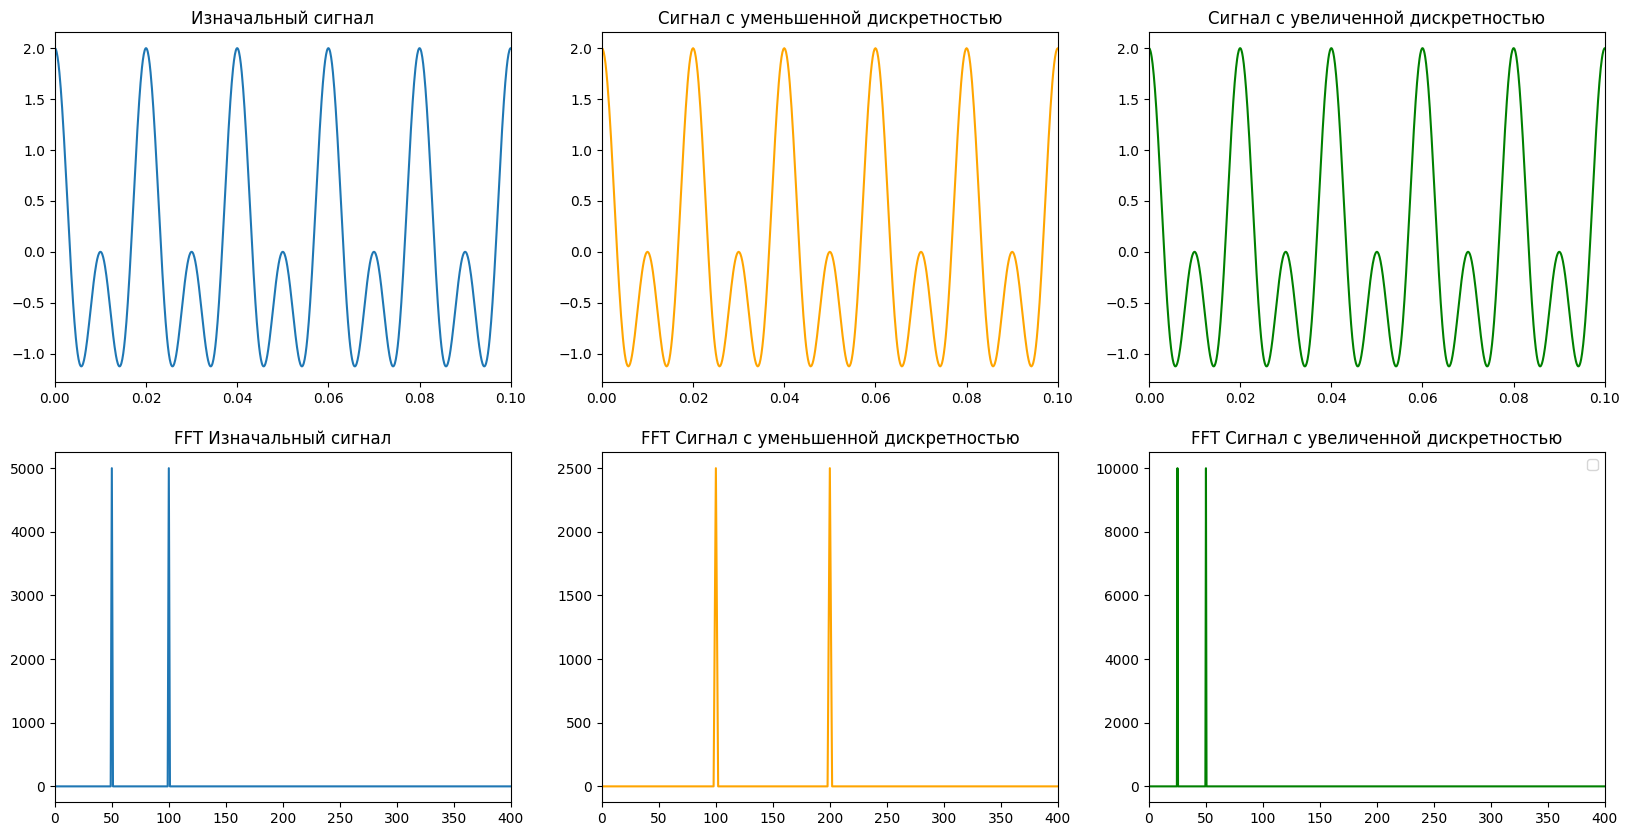

In [79]:
x = np.linspace(0, 1, fs, endpoint=False)
signal = np.cos(2 * np.pi * 50 * x) + np.cos(2 * np.pi * 100 * x)
signal_fft, y_fft = compute_spectrum(signal, fs)

down_factor = 2
downsampled_signal, new_sampling_rate_down = downsample_signal(signal, fs, down_factor)
downsampled_signal_fft, downsampled_y_fft = compute_spectrum(downsampled_signal, fs)

up_factor = 2
upsampled_signal, new_sampling_rate_up = upsample_signal(signal, fs, up_factor)
upsampled_signal_fft, upsampled_y_fft = compute_spectrum(upsampled_signal, fs)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.title("Изначальный сигнал")
plt.xlim(0.0, 0.1)
plt.plot(x, signal)

plt.subplot(2, 3, 2)
plt.title("Сигнал с уменьшенной дискретностью")
plt.xlim(0.0, 0.1)
plt.plot(np.linspace(0, 1, len(downsampled_signal), endpoint=False), downsampled_signal, color='orange')

plt.subplot(2, 3, 3)
plt.title("Сигнал с увеличенной дискретностью")
plt.xlim(0.0, 0.1)
plt.plot(np.linspace(0, 1, len(upsampled_signal), endpoint=False), upsampled_signal, color='green')

plt.subplot(2, 3, 4)
plt.title("FFT Изначальный сигнал")
plt.plot(signal_fft, y_fft)
plt.xlim(0, 400)

plt.subplot(2, 3, 5)
plt.title("FFT Сигнал с уменьшенной дискретностью")
plt.plot(downsampled_signal_fft, downsampled_y_fft, color='orange')
plt.xlim(0, 400)

plt.subplot(2, 3, 6)
plt.title("FFT Сигнал с увеличенной дискретностью")
plt.plot(upsampled_signal_fft, upsampled_y_fft, color='green')
plt.xlim(0, 400)

plt.legend()

# 5.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def resample_signal(signal, original_rate, target_rate):
    # Создаем временные оси для исходного и нового сигналов
    original_time = np.linspace(0, len(signal) / original_rate, len(signal), endpoint=False)
    target_time = np.linspace(0, len(signal) / original_rate, int(len(signal) * target_rate / original_rate), endpoint=False)
    
    # Выполняем интерполяцию
    resampled_signal = np.interp(target_time, original_time, signal)

    # resampled_signal = np.zeros(len(target_time))
    
    # # Линейная интерполяция
    # for i, t in enumerate(target_time):
    #     # Находим два ближайших времени из оригинальной оси
    #     idx_left = np.searchsorted(original_time, t) - 1
    #     idx_right = idx_left + 1

    #     # Если target_time находится вне исходных временных данных, просто копируем граничное значение
    #     if idx_left < 0:
    #         resampled_signal[i] = signal[0]
    #     elif idx_right >= len(signal):
    #         resampled_signal[i] = signal[-1]
    #     else:
    #         # Интерполируем значение
    #         t_left = original_time[idx_left]
    #         t_right = original_time[idx_right]
    #         y_left = signal[idx_left]
    #         y_right = signal[idx_right]

    #         # Линейная интерполяция
    #         resampled_signal[i] = y_left + (t - t_left) * (y_right - y_left) / (t_right - t_left)
    
    return resampled_signal

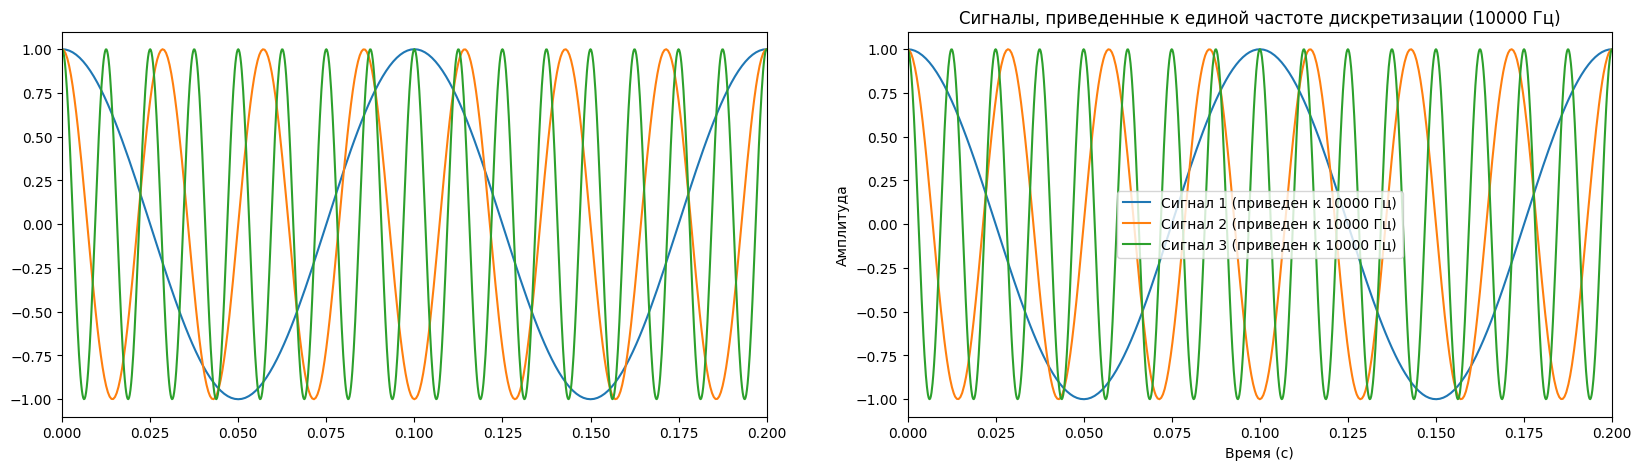

In [100]:
freq1, freq2, freq3 = 10, 35, 80 
sampling_rate1, sampling_rate2, sampling_rate3 = 1000, 2000, 5000
duration = 1

t1 = np.linspace(0, duration, int(sampling_rate1 * duration), endpoint=False)
t2 = np.linspace(0, duration, int(sampling_rate2 * duration), endpoint=False)
t3 = np.linspace(0, duration, int(sampling_rate3 * duration), endpoint=False)

signal1 = np.cos(2 * np.pi * freq1 * t1)
signal2 = np.cos(2 * np.pi * freq2 * t2)
signal3 = np.cos(2 * np.pi * freq3 * t3)

target_sampling_rate = 10000  # Общая частота дискретизации
resampled_signal1 = resample_signal(signal1, sampling_rate1, target_sampling_rate)
resampled_signal2 = resample_signal(signal2, sampling_rate2, target_sampling_rate)
resampled_signal3 = resample_signal(signal3, sampling_rate3, target_sampling_rate)

t_target = np.arange(0, duration, 1 / target_sampling_rate)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(t1, signal1, label=f"Сигнал 1")
plt.plot(t2, signal2, label=f"Сигнал 2")
plt.plot(t3, signal3, label=f"Сигнал 3")
plt.xlim(0.0, 0.2)

plt.subplot(1, 2, 2)
plt.plot(t_target, resampled_signal1, label=f"Сигнал 1 (приведен к {target_sampling_rate} Гц)")
plt.plot(t_target, resampled_signal2, label=f"Сигнал 2 (приведен к {target_sampling_rate} Гц)")
plt.plot(t_target, resampled_signal3, label=f"Сигнал 3 (приведен к {target_sampling_rate} Гц)")
plt.xlim(0.0, 0.2)
plt.title(f"Сигналы, приведенные к единой частоте дискретизации ({target_sampling_rate} Гц)")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.legend()